#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Hurst and RSI Strategy

This strategy has been shown to perform decently for BTC on for a smaller time period between April and July of 2020. Of course, that result only means there is merit in exploring and optimizing this strategy further. However, this proves tricky, as there is a bottleneck in working with this strategy -- the calculation of the Hurst exponents over time. 

Even though it takes only 2-3 ms to calculate the Hurst exponent for a period of 180 minutes, that speed is simply impractical when the need is to calculate rolling Hurst exponents for every minute for 1 or 2 years of data. We might not want to calculate our Hurst exponents for 180 minutes; maybe 240 or 300 minutes would be better for this strategy. It would thus take unbearably long to optimize the strategy with this bottleneck. 

This notebook offers a solution to this type of issue through two workarounds:
- Calculate the Hurst exponents only when necessary 
- Modify the objective function for the optimization process to facilitate the first workaround

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
%matplotlib inline

import ta
from hurst import compute_Hc
import empyrical
import optuna

In [2]:
df = pd.read_csv('data/btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [3]:
df.index = df.index.tz_localize(None)

In [4]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00,3688.5,3690.5,3688.5,3690.5,194.159810


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 839521 entries, 2019-01-01 00:00:00 to 2020-08-06 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   839521 non-null  float64
 1   high    839521 non-null  float64
 2   low     839521 non-null  float64
 3   open    839521 non-null  float64
 4   volume  839521 non-null  float64
dtypes: float64(5)
memory usage: 38.4 MB


In [13]:
# it takes 2.7 ms on my old computer to calculate the Hurst exponent for 200 data points

%timeit compute_Hc(df.close.iloc[:200], kind='price')

2.69 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [5]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [6]:
# Hurst and RSI strategy function 

def hurst_trending_strategy_optimize(data, upper_rsi, lower_rsi, upper_hurst, 
                                     lower_hurst, profit_taking=.04, stop_loss=-.015):
    long_pos = False
    short_pos = False

    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    filled_price = 0
    PnL = 1
    cumRet = []
    
    # loop through every row of the minute dataset
    for row in data.itertuples():
        current_price = row.close
        has_pos = long_pos + short_pos
        rsi = row.rsi
        hurst = row.hurst
        
        # put on trades
        if not has_pos:
            if rsi > upper_rsi and hurst < lower_hurst or rsi < lower_rsi and hurst > upper_hurst:
                filled_price = row.open*.995    # slippage incorporated
                short_pos = True              
            elif rsi > upper_rsi and hurst > upper_hurst or rsi < lower_rsi and hurst < lower_hurst:
                filled_price = row.open*1.005   # slippage incorporated
                long_pos = True

        # take profits or stop losses
        else:
            if short_pos:
                prct_changed = (filled_price-current_price)/filled_price
            else:
                prct_changed = (current_price-filled_price)/filled_price
            if prct_changed >= profit_taking:
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)    # record realized PnL
                take_profit += 1
            elif prct_changed <= stop_loss:
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed-.005)    # # slippage incorporated
                stopped_out += 1
        cumRet.append(PnL)
    
    cumRet = pd.Series(cumRet, index=data.index)
    print('__take profits:', take_profit, '\nstopped out:', stopped_out)

    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))

### First workaround:

The next two functions (*hurst_calculate* and *process_data_hurst_strategy*) calculate the Hurst exponents only when necessary. 

Since we go long or short in this strategy when both the RSI and Hurst exponents cross certain thresholds, we will only calculate the Hurst exponents when the thresholds for the RSI are crossed. This reduces the number of Hurst exponents to calculate from 500,000 to 1,000,000 for a 1 to 2 year period down to 10,000 to 20,000. That is a drastic decrease in calculation and increase in speed for the optimization process. 

In [7]:
def hurst_calculate(data, window, col_name):
    '''
    data must already include a column with col_name for when to calculate hurst exponents
    data must also include a column called 'close' for the closing prices of candles
    data must be minute pricing data with timestamp for index
    '''
    from datetime import timedelta
    col1 = data[col_name]!=0
    col2 = data[col_name]!=0
    for i in range(1,window+1,1):
        col2 = col1.shift(-i).fillna(False) | col2
    col1 = data.loc[col1, 'close']
    col2 = data.loc[col2, 'close']
    result = np.zeros(col1.shape[0])
    for i in range(col1.shape[0]):
        start = col1.index[i] - timedelta(minutes=window)
        end = col1.index[i]
        result[i] = compute_Hc(col2.loc[start:end], kind='price')[0]
    return pd.Series(result, index=col1.index)

In [46]:
# process data to be used by the strategy function
# there must be at least 5000 Hurst exponents to make it worth calculating
# as a smaller number is unlikely to lead to enough trades to make for a robust strategy

def process_data_hurst_strategy(data, rsi_window, upper_rsi, lower_rsi, hurst_window):
    data['rsi'] = ta.momentum.rsi(data.close.shift(1), rsi_window)
    data['signal'] = 0
    data.loc[(data.rsi>upper_rsi)|(data.rsi<lower_rsi),'signal'] = 1
    print('hurst exponents to calculate: ', data.signal.sum())
    if data.signal.sum() < 2500:   # change threshold depending on the length of the time window of the data
        raise optuna.TrialPruned()
    data.loc[:,'signal'].iloc[:hurst_window] = 0   # to avoid calculating hurst exponent before hurst_window 
    data['hurst'] = hurst_calculate(data, hurst_window, 'signal')

### Second workaround:

The following objective function has been modified from the typical objective function for other strategy:
- the trial object still handles parameter suggestion but only for four of the six parameters we want to optimize
   - these four parameters determine the number of Hurst exponents to calculate, after which we can freely/quickly search a host of values for the upper and lower barrier for the Hurst exponents.
- this function prevents wasting time processing data for the same parameters' values as those suggested in past iteration of the objective function. This is an issue with Optuna's sampler methodology.  

In [52]:
def objective(trial, data, partial_param_list, num_inner_trials=10):
    # trial object still handles parameters' value suggestions but only for four parameters out of six
    upper_rsi = trial.suggest_discrete_uniform('upper_rsi', 70, 90, 5)
    lower_rsi = trial.suggest_discrete_uniform('lower_rsi', 20, 35, 5)
    rsi_window = int(trial.suggest_discrete_uniform('rsi_window', 15, 120, 5))
    hurst_window = int(trial.suggest_discrete_uniform('hurst_window', 120, 600, 10))
    
    # if trial suggests the same parameters' values as those in previous iteration, stop there and move on 
    params = {'ur':upper_rsi, 'lr':lower_rsi, 'rw':rsi_window, 'hw':hurst_window}
    if params in partial_param_list:
        raise optuna.TrialPruned()
    partial_param_list.append(params)
    
    # calculate the Hurst exponents based on the suggested values of the other four parameters
    process_data_hurst_strategy(data, rsi_window, upper_rsi, lower_rsi, hurst_window) 
    
    # quickly optimize the over the parameter's space for the other two parameters
    pmdd = []
    hurst_thresholds = []
    for i in range(num_inner_trials):    
        upper_hurst = .65 + .025*np.random.randint(0, 9)
        lower_hurst = .2 + .025*np.random.randint(0, 9)
        pmdd.append(hurst_trending_strategy_optimize(data, upper_rsi, lower_rsi, upper_hurst, lower_hurst)[1])
        hurst_thresholds.append((upper_hurst, lower_hurst))
    
    # pick the best values for the two hurst parameters to return 
    # for this particular iteration of the objective function
    best_uhlh = hurst_thresholds[np.argmax(pmdd)]
    trial.set_user_attr('params_upper_hurst', best_uhlh[0])
    trial.set_user_attr('params_lower_hurst', best_uhlh[1])
    
    return np.nanmax(pmdd)

In [25]:
data = df.loc[:'2019-12-31'].copy()

In [53]:
study = optuna.create_study(direction='maximize')

In [54]:
partial_param_list = []

In [59]:
study.optimize(lambda trial: objective(trial, data.copy(), partial_param_list, 30), n_trials=50)

hurst exponents to calculate:  2424


[I 2020-08-08 15:19:25,971] Trial 150 pruned. 


hurst exponents to calculate:  6563
__take profits: 19 
stopped out: 37
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 19 
stopped out: 38
__take profits: 14 
stopped out: 27
__take profits: 6 
stopped out: 10
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 5
__take profits: 2 
stopped out: 1
__take profits: 6 
stopped out: 23
__take profits: 1 
stopped out: 0
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 2
__take profits: 3 
stopped out: 8
__take profits: 6 
stopped out: 3
__take profits: 6 
stopped out: 3
__take profits: 6 
stopped out: 3
__take profits: 0 
stopped out: 0
__take profits: 19 
stopped out: 37
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 6 
stopped out: 23
__take profits: 9 
stopped out: 6
__take profits: 9 
stopped out: 6
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 5
__take profits: 19 
stopped out: 37

[I 2020-08-08 15:20:37,190] Trial 151 finished with value: 0.009021643766405879 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 35.0, 'hurst_window': 400.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  9658
__take profits: 24 
stopped out: 40
__take profits: 0 
stopped out: 0
__take profits: 6 
stopped out: 4
__take profits: 24 
stopped out: 39
__take profits: 24 
stopped out: 40
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 1
__take profits: 12 
stopped out: 20
__take profits: 6 
stopped out: 4
__take profits: 9 
stopped out: 9
__take profits: 4 
stopped out: 1
__take profits: 5 
stopped out: 11
__take profits: 24 
stopped out: 40
__take profits: 34 
stopped out: 65
__take profits: 12 
stopped out: 35
__take profits: 5 
stopped out: 11
__take profits: 4 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 5 
stopped out: 11
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 9
__take profits: 12 
stopped out: 21
__take profits: 5 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 12 
stopped out: 21
__take profits: 0 
stopp

[I 2020-08-08 15:21:56,576] Trial 152 finished with value: 0.04878956159625639 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 30.0, 'hurst_window': 390.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:21:56,608] Trial 153 pruned. 
[I 2020-08-08 15:21:56,630] Trial 154 pruned. 


hurst exponents to calculate:  4484
__take profits: 7 
stopped out: 4
__take profits: 18 
stopped out: 30
__take profits: 5 
stopped out: 3
__take profits: 3 
stopped out: 3
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 7
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 4
__take profits: 4 
stopped out: 18
__take profits: 8 
stopped out: 5
__take profits: 8 
stopped out: 20
__take profits: 18 
stopped out: 30
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 4
__take profits: 0 
stopped out: 0
__take profits: 1 
stopped out: 1
__take profits: 4 
stopped out: 18
__take profits: 0 
stopped out: 0
__take profits: 5 
stopped out: 3
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 21 
stopped out: 43
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 4
__take profits: 3 
stopped out: 3
__take profits: 11 
stopped out: 15
__take profits: 13 
stopped out: 31

[I 2020-08-08 15:23:00,423] Trial 155 finished with value: -0.010100251520062657 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 40.0, 'hurst_window': 390.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  1260


[I 2020-08-08 15:23:00,556] Trial 156 pruned. 
[I 2020-08-08 15:23:00,587] Trial 157 pruned. 
[I 2020-08-08 15:23:00,618] Trial 158 pruned. 


hurst exponents to calculate:  1540


[I 2020-08-08 15:23:00,756] Trial 159 pruned. 


hurst exponents to calculate:  1877


[I 2020-08-08 15:23:00,903] Trial 160 pruned. 
[I 2020-08-08 15:23:00,941] Trial 161 pruned. 
[I 2020-08-08 15:23:00,957] Trial 162 pruned. 
[I 2020-08-08 15:23:00,988] Trial 163 pruned. 
[I 2020-08-08 15:23:01,004] Trial 164 pruned. 


hurst exponents to calculate:  16454
__take profits: 7 
stopped out: 14
__take profits: 7 
stopped out: 13
__take profits: 23 
stopped out: 63
__take profits: 23 
stopped out: 64
__take profits: 0 
stopped out: 2
__take profits: 7 
stopped out: 13
__take profits: 7 
stopped out: 13
__take profits: 7 
stopped out: 14
__take profits: 0 
stopped out: 1
__take profits: 13 
stopped out: 31
__take profits: 23 
stopped out: 64
__take profits: 13 
stopped out: 31
__take profits: 0 
stopped out: 0
__take profits: 4 
stopped out: 7
__take profits: 26 
stopped out: 74
__take profits: 4 
stopped out: 3
__take profits: 6 
stopped out: 16
__take profits: 17 
stopped out: 49
__take profits: 23 
stopped out: 63
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 1
__take profits: 17 
stopped out: 49
__take profits: 7 
stopped out: 13
__take profits: 7 
stopped out: 13
__take profits: 0 
stopped out: 1
__take profits: 23 
stopped out: 64
__take profits: 0 
stopped out: 1
__take profits: 4

[I 2020-08-08 15:24:43,459] Trial 165 finished with value: -0.06773283181652287 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 30.0, 'rsi_window': 30.0, 'hurst_window': 390.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  14701
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 1
__take profits: 32 
stopped out: 82
__take profits: 5 
stopped out: 13
__take profits: 0 
stopped out: 1
__take profits: 2 
stopped out: 2
__take profits: 16 
stopped out: 25
__take profits: 5 
stopped out: 13
__take profits: 25 
stopped out: 61
__take profits: 0 
stopped out: 0
__take profits: 32 
stopped out: 82
__take profits: 7 
stopped out: 7
__take profits: 9 
stopped out: 33
__take profits: 0 
stopped out: 0
__take profits: 16 
stopped out: 25
__take profits: 25 
stopped out: 60
__take profits: 9 
stopped out: 33
__take profits: 2 
stopped out: 1
__take profits: 9 
stopped out: 33
__take profits: 24 
stopped out: 50
__take profits: 4 
stopped out: 2
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 7
__take profits: 2 
stopped out: 2
__take profits: 5 
stopped out: 13
__take profits: 11 
stopp

[I 2020-08-08 15:26:19,290] Trial 166 finished with value: -0.014979994763818772 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 25.0, 'hurst_window': 400.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:26:19,321] Trial 167 pruned. 
[I 2020-08-08 15:26:19,341] Trial 168 pruned. 


hurst exponents to calculate:  5639
__take profits: 0 
stopped out: 0
__take profits: 4 
stopped out: 16
__take profits: 0 
stopped out: 2
__take profits: 0 
stopped out: 2
__take profits: 1 
stopped out: 3
__take profits: 0 
stopped out: 0
__take profits: 12 
stopped out: 20
__take profits: 12 
stopped out: 20
__take profits: 18 
stopped out: 39
__take profits: 0 
stopped out: 0
__take profits: 18 
stopped out: 39
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 2
__take profits: 1 
stopped out: 3
__take profits: 1 
stopped out: 6
__take profits: 18 
stopped out: 39
__take profits: 18 
stopped out: 39
__take profits: 1 
stopped out: 5
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 3
__take profits: 12 
stopped out: 23
__take profits: 0 
stopped out: 0
__take profits: 3 
stopped out: 13
__take profits: 18 
stopped o

[I 2020-08-08 15:27:31,189] Trial 169 finished with value: -0.1461389521789334 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 30.0, 'rsi_window': 45.0, 'hurst_window': 450.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:27:31,211] Trial 170 pruned. 
[I 2020-08-08 15:27:31,226] Trial 171 pruned. 
[I 2020-08-08 15:27:31,258] Trial 172 pruned. 
[I 2020-08-08 15:27:31,273] Trial 173 pruned. 
[I 2020-08-08 15:27:31,304] Trial 174 pruned. 


hurst exponents to calculate:  3257
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 12
__take profits: 6 
stopped out: 5
__take profits: 2 
stopped out: 8
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 8
__take profits: 0 
stopped out: 0
__take profits: 10 
stopped out: 13
__take profits: 5 
stopped out: 2
__take profits: 5 
stopped out: 3
__take profits: 16 
stopped out: 25
__take profits: 5 
stopped out: 5
__take profits: 6 
stopped out: 5
__take profits: 6 
stopped out: 6
__take profits: 6 
stopped out: 6
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 8
__take profits: 0 
stopped out: 0
__take profits: 5 
stopped out: 2
__take profits: 16 
stopped out: 26
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 16 
stopped out: 24
__take profits: 16 
stopped out: 26
__take profits: 2 
stopped out: 8
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 10 
stopped out: 13

[I 2020-08-08 15:28:31,977] Trial 175 finished with value: 0.03125435054443658 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 45.0, 'hurst_window': 390.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:28:32,005] Trial 176 pruned. 
[I 2020-08-08 15:28:32,027] Trial 177 pruned. 
[I 2020-08-08 15:28:32,047] Trial 178 pruned. 


hurst exponents to calculate:  3257
__take profits: 1 
stopped out: 2
__take profits: 2 
stopped out: 0
__take profits: 5 
stopped out: 9
__take profits: 0 
stopped out: 0
__take profits: 1 
stopped out: 2
__take profits: 12 
stopped out: 8
__take profits: 12 
stopped out: 10
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 0
__take profits: 2 
stopped out: 0
__take profits: 15 
stopped out: 26
__take profits: 5 
stopped out: 9
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 11 
stopped out: 13
__take profits: 12 
stopped out: 8
__take profits: 4 
stopped out: 2
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 0
__take profits: 9 
stopped out: 4
__take profits: 0 
stopped out: 0
__take profits: 7 
stopped out: 11
__take profits: 15 
stopped out: 25
__take profits: 15 
stopped out: 25
__take profits: 4 
stopped out: 2
__take profits: 4 
stopped out: 2
__take profits: 0 
stopped out: 0
__take profits: 12 
stopped out: 

[I 2020-08-08 15:29:34,171] Trial 179 finished with value: 0.1378553705403513 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 45.0, 'hurst_window': 420.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:29:34,191] Trial 180 pruned. 
[I 2020-08-08 15:29:34,222] Trial 181 pruned. 


hurst exponents to calculate:  1877


[I 2020-08-08 15:29:34,364] Trial 182 pruned. 
[I 2020-08-08 15:29:34,386] Trial 183 pruned. 
[I 2020-08-08 15:29:34,417] Trial 184 pruned. 
[I 2020-08-08 15:29:34,433] Trial 185 pruned. 


hurst exponents to calculate:  9658
__take profits: 1 
stopped out: 4
__take profits: 4 
stopped out: 10
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 2
__take profits: 10 
stopped out: 9
__take profits: 0 
stopped out: 0
__take profits: 8 
stopped out: 27
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 1
__take profits: 4 
stopped out: 11
__take profits: 15 
stopped out: 16
__take profits: 18 
stopped out: 18
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 2
__take profits: 0 
stopped out: 1
__take profits: 5 
stopped out: 14
__take profits: 0 
stopped out: 0
__take profits: 5 
stopped out: 14
__take profits: 10 
stopped out: 9
__take profits: 0 
stopped out: 1
__take profits: 3 
stopped out: 2
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 8 
stopped out: 28


[I 2020-08-08 15:30:58,925] Trial 186 finished with value: 0.07741341526370112 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 30.0, 'hurst_window': 440.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  7584
__take profits: 11 
stopped out: 39
__take profits: 0 
stopped out: 0
__take profits: 12 
stopped out: 40
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 29
__take profits: 0 
stopped out: 1
__take profits: 4 
stopped out: 10
__take profits: 0 
stopped out: 1
__take profits: 7 
stopped out: 22
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 1
__take profits: 12 
stopped out: 39
__take profits: 1 
stopped out: 2
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 6 
stopped out: 19
__take profits: 1 
stopped out: 2
__take profits: 12 
stopped out: 40
__take profits: 7 
stopped out: 22
__take profits: 12 
stopped out: 39
__take profits: 16 
stopped out: 55
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 3 
stopped out: 8
__take profits: 7 
stopped out: 22
__take profits: 12 
stopped 

[I 2020-08-08 15:32:17,182] Trial 187 finished with value: -0.1289994830144471 and parameters: {'upper_rsi': 90.0, 'lower_rsi': 30.0, 'rsi_window': 30.0, 'hurst_window': 440.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  2424


[I 2020-08-08 15:32:17,330] Trial 188 pruned. 


hurst exponents to calculate:  14701
__take profits: 0 
stopped out: 0
__take profits: 29 
stopped out: 58
__take profits: 16 
stopped out: 23
__take profits: 4 
stopped out: 2
__take profits: 7 
stopped out: 33
__take profits: 16 
stopped out: 23
__take profits: 16 
stopped out: 23
__take profits: 0 
stopped out: 0
__take profits: 6 
stopped out: 13
__take profits: 23 
stopped out: 53
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 28 
stopped out: 57
__take profits: 2 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 23 
stopped out: 53
__take profits: 28 
stopped out: 57
__take profits: 28 
stopped out: 57
__take profits: 29 
stopped out: 58
__take profits: 0 
stopped out: 0
__take profits: 17 
stopped out: 24
__take profits: 0 
stopped out: 0
__take profits: 10 
stopped out: 35
__take profits: 28 
stopped out: 57
__take profits: 1 
stopped out: 1
__take profits: 30 
stopped out: 65
__take profits: 0 
stopped out: 0
__take profits

[I 2020-08-08 15:34:02,478] Trial 189 finished with value: -0.010624256893966354 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 25.0, 'hurst_window': 470.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:34:02,498] Trial 190 pruned. 


hurst exponents to calculate:  9658
__take profits: 10 
stopped out: 35
__take profits: 0 
stopped out: 0
__take profits: 24 
stopped out: 68
__take profits: 0 
stopped out: 0
__take profits: 24 
stopped out: 68
__take profits: 21 
stopped out: 43
__take profits: 14 
stopped out: 16
__take profits: 18 
stopped out: 44
__take profits: 14 
stopped out: 18
__take profits: 4 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 24 
stopped out: 50
__take profits: 0 
stopped out: 1
__take profits: 6 
stopped out: 32
__take profits: 0 
stopped out: 0
__take profits: 24 
stopped out: 68
__take profits: 4 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 18 
stopped out: 44
__take profits: 5 
stopped out: 3
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 6 
stopped out: 11
__take profits: 0 
stopped out: 0
__take profits: 9 
stopped out: 6
__take profits: 2 
stopped out: 0
__take profits: 5 
stopped out: 3
__take profits: 0 
sto

[I 2020-08-08 15:35:24,748] Trial 191 finished with value: 0.028385898976773905 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 30.0, 'hurst_window': 420.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:35:24,768] Trial 192 pruned. 
[I 2020-08-08 15:35:24,799] Trial 193 pruned. 
[I 2020-08-08 15:35:24,819] Trial 194 pruned. 
[I 2020-08-08 15:35:24,847] Trial 195 pruned. 


hurst exponents to calculate:  4484
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 3 
stopped out: 2
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 2
__take profits: 19 
stopped out: 32
__take profits: 2 
stopped out: 12
__take profits: 0 
stopped out: 0
__take profits: 2 
stopped out: 13
__take profits: 19 
stopped out: 33
__take profits: 0 
stopped out: 0
__take profits: 19 
stopped out: 32
__take profits: 0 
stopped out: 3
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 19 
stopped out: 32
__take profits: 2 
stopped out: 12
__take profits: 0 
stopped out: 2
__take profits: 19 
stopped out: 34
__take profits: 0 
stopped out: 0
__take profits: 0 
stopped out: 0
__take profits: 19 
stopped out: 32
__take profits: 3 
stopped out: 2
__take profits: 3 
stopped out: 2
__take profits: 3 
stopped out: 2
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out:

[I 2020-08-08 15:36:35,712] Trial 196 finished with value: -0.06678371000853392 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 20.0, 'rsi_window': 40.0, 'hurst_window': 460.0}. Best is trial 100 with value: 0.1861570342398805.
[I 2020-08-08 15:36:35,744] Trial 197 pruned. 


hurst exponents to calculate:  16454
__take profits: 0 
stopped out: 1
__take profits: 29 
stopped out: 67
__take profits: 1 
stopped out: 1
__take profits: 9 
stopped out: 14
__take profits: 1 
stopped out: 1
__take profits: 0 
stopped out: 1
__take profits: 1 
stopped out: 1
__take profits: 25 
stopped out: 62
__take profits: 5 
stopped out: 8
__take profits: 0 
stopped out: 1
__take profits: 26 
stopped out: 62
__take profits: 2 
stopped out: 1
__take profits: 16 
stopped out: 44
__take profits: 3 
stopped out: 17
__take profits: 5 
stopped out: 8
__take profits: 0 
stopped out: 1
__take profits: 0 
stopped out: 0
__take profits: 17 
stopped out: 31
__take profits: 2 
stopped out: 1
__take profits: 26 
stopped out: 62
__take profits: 0 
stopped out: 0
__take profits: 3 
stopped out: 17
__take profits: 9 
stopped out: 15
__take profits: 0 
stopped out: 0
__take profits: 29 
stopped out: 67
__take profits: 3 
stopped out: 17
__take profits: 2 
stopped out: 1
__take profits: 11 
stoppe

[I 2020-08-08 15:38:17,384] Trial 198 finished with value: -0.03853292163438282 and parameters: {'upper_rsi': 70.0, 'lower_rsi': 30.0, 'rsi_window': 30.0, 'hurst_window': 400.0}. Best is trial 100 with value: 0.1861570342398805.


hurst exponents to calculate:  1260


[I 2020-08-08 15:38:17,531] Trial 199 pruned. 


In [61]:
study.best_params

{'upper_rsi': 70.0,
 'lower_rsi': 20.0,
 'rsi_window': 40.0,
 'hurst_window': 420.0}

In [60]:
study.best_value

0.1861570342398805

In [62]:
trials = study.trials_dataframe()

In [63]:
trials.sort_values('value', ascending=False).iloc[:20]

,number,value,datetime_start,datetime_complete,duration,params_hurst_window,params_lower_rsi,params_rsi_window,params_upper_rsi,user_attrs_params_lower_hurst,user_attrs_params_upper_hurst,state
100,100,0.186157,2020-08-08 14:36:35.662877,2020-08-08 14:37:42.036464,00:01:06.373587,420.0,20.0,40.0,70.0,0.200,0.850,COMPLETE
97,97,0.147396,2020-08-08 12:28:34.600806,2020-08-08 12:29:48.544678,00:01:13.943872,440.0,20.0,35.0,70.0,0.200,0.800,COMPLETE
179,179,0.137855,2020-08-08 15:28:32.055992,2020-08-08 15:29:34.171276,00:01:02.115284,420.0,20.0,45.0,70.0,0.325,0.750,COMPLETE
137,137,0.099308,2020-08-08 15:03:56.432718,2020-08-08 15:04:59.600955,00:01:03.168237,440.0,20.0,45.0,70.0,0.325,0.800,COMPLETE
127,127,0.091758,2020-08-08 15:00:45.694477,2020-08-08 15:01:48.016334,00:01:02.321857,430.0,20.0,45.0,70.0,0.250,0.750,COMPLETE
18,18,0.077866,2020-08-08 11:05:00.227643,2020-08-08 11:06:02.962396,00:01:02.734753,420.0,30.0,55.0,70.0,0.200,0.775,COMPLETE
186,186,0.077413,2020-08-08 15:29:34.433538,2020-08-08 15:30:58.925477,00:01:24.491939,440.0,20.0,30.0,70.0,0.225,0.825,COMPLETE
112,112,0.054762,2020-08-08 14:48:05.723819,2020-08-08 14:49:29.242059,00:01:23.518240,430.0,20.0,30.0,70.0,0.325,0.800,COMPLETE
104,104,0.054487,2020-08-08 14:38:47.393855,2020-08-08 14:39:54.604270,00:01:07.210415,430.0,20.0,40.0,70.0,0.275,0.800,COMPLETE
152,152,0.048790,2020-08-08 15:20:37.190946,2020-08-08 15:21:56.576985,00:01:19.386039,390.0,20.0,30.0,70.0,0.250,0.800,COMPLETE


### Test on out-of-sample data

The performance of this strategy does not appear very promising. It might not be worth pursuing further. However, the techniques presented so far in this notebook for dealing with the slow calculation of Hurst exponents should be transferable to other situations. 

In [64]:
df_test = df.loc['2020-01-01':].copy()

In [65]:
process_data_hurst_strategy(df_test, 40, 70, 20, 420)

hurst exponents to calculate:  4321


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [68]:
cumRet, pmdd = hurst_trending_strategy_optimize(df_test, 70, 20, .7, .35 )

__take profits: 5 
stopped out: 10


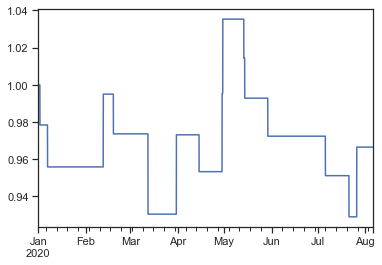

In [69]:
cumRet.plot()